In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import Tensor

from torchvision.ops import nms, box_convert
import torchvision.transforms.functional as fn
import torchmetrics

from torch.utils.data import DataLoader

c:\Users\Leonard\anaconda3\envs\pytorch_nn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import wandb
WANDB_LOGGING = False
FREEZE_FEATURE_EXTRACTOR = False
CONFIG = {
    "project_name": "card detector",
    "optimizer": {
        "lr": 0.0001,
    },
    "dataset": {
        "img_dir": "data/images/",
        "annotations_file": "data/labels.csv",
        "img_w": 640,
        "img_h": 640,
        "num_anchors_per_cell": 3,
        "anchor_box_sizes": [8192],
        "anchor_box_aspect_ratios": [0.75, 1, 1.25],

    },
    "dataloader": {
        "batch_size": 32,
    }
}

In [12]:
if WANDB_LOGGING: 
    wandb.init()

In [3]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels: int, num_anchors_per_cell: int):
        super().__init__()
        
        out_channels = num_anchors_per_cell * 5
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.conv(input)

In [4]:
class CardDetector(nn.Module):
    def __init__(self, img_dims, anchor_boxes: torch.Tensor, num_anchors_per_cell: int, loss_fn, num_max_boxes: int = 1):
        super(CardDetector, self).__init__()

        self.img_w = img_dims[0]
        self.img_h = img_dims[1]
        self.anchor_boxes = anchor_boxes
        self.num_anchors_per_cell = num_anchors_per_cell
        self.num_max_boxes = num_max_boxes

        self.loss_fn = loss_fn

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.feature_extractor = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        if FREEZE_FEATURE_EXTRACTOR:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        
        self.detection_head = DetectionHead(in_channels=512, num_anchors_per_cell=self.num_anchors_per_cell)

        dummy_image = torch.randn(1, 3, self.img_w, self.img_h)
        features_shape = self.feature_extractor(dummy_image).shape
        self.features_w = features_shape[-2]
        self.features_h = features_shape[-1]
        self.scale_w = self.img_w / self.features_w
        self.scale_h = self.img_h / self.features_h

    def forward(self, input):
        # Get feature map
        features = self.feature_extractor(input)

        # Get detection vectors for each feature
        detection = self.detection_head(features)
        detection = detection.permute(0,2,3,1).contiguous()
        detection = detection.view(detection.shape[0], detection.shape[1], detection.shape[2], self.num_anchors_per_cell, 5)

        # Apply sigmoid to the first 3 elements of the (p, cx, cy, w, h) tensor
        #detection[:, :, :, :, :3] = torch.sigmoid(detection[:, :, :, :, :3])  

        # Square the last two numbers (scales of width and height)
        #detection[:, :, :, :, 3:] = torch.square(detection[:, :, :, :, 3:])
        
        return detection

    def predict(self, input, ground_truth=None):
        self.eval()

        if (len(input.shape) == 3): # If we get a single image with shape (C x W x H) we need to add a dimension at the beginning so that the forward function can process it (only works on batched input)
            input = input.unsqueeze(0) 

        detection = self.forward(input)
        if ground_truth != None:
            detection = ground_truth

        anchor_box_scales = self.create_anchor_box_scales(detection_shape=detection.shape)
        anchor_box_offsets = self.create_anchor_box_offsets(detection_shape=detection.shape, scale_w=self.scale_w, scale_h=self.scale_h)

        #anchor_box_scales = anchor_box_scales.to(self.device)
        #anchor_box_offsets = anchor_box_offsets.to(self.device)

        detection[:,:,:,:,3:5] = torch.mul(detection[:,:,:,:,3:5], anchor_box_scales[:,:,:,:,3:5]) # multiply the w, h coords of detection with predifined anchor box w, h
        detection[:,:,:,:,1] = torch.mul(detection[:,:,:,:,1], self.scale_w)   # scale the x offset from cell orgin
        detection[:,:,:,:,2] = torch.mul(detection[:,:,:,:,2], self.scale_h)   # scale the y offset from cell origin
        detection[:,:,:,:,1:3] = torch.add(detection[:,:,:,:,1:3], anchor_box_offsets[:,:,:,:,1:3])   # add offset from image origin

        # Apply sigmoid to the objectness scores
        detection[:,:,:,:,0] = torch.sigmoid(detection[:,:,:,:,0])

        wh_offsets = detection[:, :, :, :, 3:5].clone()
        wh_offsets = torch.mul(wh_offsets, 0.5)

        cx_cy = detection[:, :, :, :, 1:3].clone()

        pred_boxes = detection.clone()
        pred_boxes[:, :, :, :, 1:3] = torch.add(cx_cy, -1 * wh_offsets)
        pred_boxes[:, :, :, :, 3:5] = torch.add(cx_cy, wh_offsets)
        
        pred_boxes = pred_boxes.view(-1, pred_boxes.shape[1] * pred_boxes.shape[2] * self.num_anchors_per_cell, 5)

        for image in pred_boxes:
            boxes =  image[:, 1:]  # select the coordinate values
            objectness_scores = image[:, :1].squeeze(dim=1) # select the objectness score values, the squeeze to get rid of the extra dimension

            indices_to_keep = nms(boxes=boxes, scores=objectness_scores, iou_threshold=0.5)
            kept_boxes = boxes[indices_to_keep[:self.num_max_boxes]]
            kept_obj_scores = objectness_scores[indices_to_keep[:self.num_max_boxes]]

            print(kept_boxes, kept_obj_scores)
            return kept_boxes
        
    def create_anchor_box_offsets(self, detection_shape, scale_w, scale_h):
        addition_tensor = torch.zeros(detection_shape[0], detection_shape[1], detection_shape[2], detection_shape[3], detection_shape[4])
        for i in range(detection_shape[1]):
            for j in range(detection_shape[2]):
                addition_tensor[:, i, j, :, 1] = i * scale_w
                addition_tensor[:, i, j, :, 2] = j * scale_h      
        return addition_tensor

    def create_anchor_box_scales(self, detection_shape):
        tensor = torch.zeros(detection_shape[0], detection_shape[1], detection_shape[2], detection_shape[3], detection_shape[4])

        for k in range(detection_shape[3]): # num of anchors
            tensor[:, :, :, k, 3] = self.anchor_boxes[k][0]
            tensor[:, :, :, k, 4] = self.anchor_boxes[k][1]
        return tensor

In [5]:
def generate_anchor_boxes(sizes, aspect_ratios) -> torch.Tensor:    #TODO: rework how we generate anchor boxes - K-means from dataset, probably
    anchor_boxes = []
    for size in sizes:
        for aspect_ratio in aspect_ratios:
            width = int((size * aspect_ratio) ** 0.5)
            height = int((size / aspect_ratio) ** 0.5)
            anchor_boxes.append((width, height))
    return torch.tensor(anchor_boxes)

In [6]:
from tqdm.auto import tqdm  # We use tqdm to display a simple progress bar, allowing us to observe the learning progression.
from torchmetrics.detection import mean_ap

def fit(
  model: nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  train_dataloader: DataLoader,
  val_dataloader: DataLoader,
  device: str,
  print_rate: int = 100
  ):
    # TODO: figure out accuacy
    #accuracy = torchmetrics.Accuracy(task='multiclass', average="weighted").to(model.device)
    accuracy = None
    model = model.to(device=device)
    box_loss = nn.MSELoss()
    obj_loss = nn.BCEWithLogitsLoss()
    
    # Iterate through epochs with tqdm
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch: {epoch}\n")
        train_loss = 0
        model.train()  # Set model to train
        
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            pred_boxes = outputs[..., 1:]
            pred_obj = outputs[..., 0]

            true_boxes = y[..., 1:]
            true_obj = y[..., 0]
            
             # localization loss
            box_loss_value = box_loss(pred_boxes, true_boxes)
            
            # objectness loss
            obj_loss_value = obj_loss(pred_obj, true_obj)

            # total loss
            loss = box_loss_value + obj_loss_value
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            if batch % print_rate == 0: 
                print(f"Looked at {batch} Batches\t---\t{batch * len(X)}/{len(train_dataloader.dataset)} Samples")
            elif batch == len(train_dataloader) - 1:
                print(f"Looked at {batch} Batches\t---\t{len(train_dataloader.dataset)}/{len(train_dataloader.dataset)} Samples")
        
        # Divide the train_loss by the number of batches to get the average train_loss
        avg_train_loss = train_loss / len(train_dataloader)

        # Validation
        # Setup the Val Loss and Accuracy to accumulate over the batches in the val dataset
        val_loss = 0
        val_acc = 0
        ## Set model to evaluation mode and use torch.inference_mode to remove unnecessary training operations 
        model.eval()
        with torch.inference_mode():
            for X_val, y_val in val_dataloader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                # localization loss
                box_loss_value = box_loss(pred_boxes, true_boxes)
                # objectness loss
                obj_loss_value = obj_loss(pred_obj, true_obj)
                # total loss
                loss = box_loss_value + obj_loss_value
                val_loss += loss.item()

                #TODO: calculate accuracy
#
        ## Get the average Val Loss and Accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_acc = val_acc / len(val_dataloader)
#
        print(f"Train loss: {avg_train_loss} | Val Loss: {avg_val_loss} | Val Accuracy: {avg_val_acc}")
        if WANDB_LOGGING:
            wandb.log({"Train Loss": avg_train_loss,"Val Loss": avg_val_loss, "Val Accuracy": avg_val_acc})

In [7]:
from dataloader_utils import MTGCardsDataset, ImageTransformer
from torchvision.utils import draw_bounding_boxes

transformer = ImageTransformer()
transform_pipe = transformer.get_transform_pipe(img_w=CONFIG["dataset"]["img_w"], img_h=CONFIG["dataset"]["img_h"])

anchor_boxes = generate_anchor_boxes(sizes=CONFIG["dataset"]["anchor_box_sizes"], aspect_ratios=CONFIG["dataset"]["anchor_box_aspect_ratios"])

model = CardDetector(img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
                      anchor_boxes=anchor_boxes,
                        num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
                          loss_fn=nn.L1Loss(reduction="sum")
                          )

dummy_image = torch.randn(1, 3, CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]) # create a dummy image to pass to the model and get feature map size
feature_map_shape = model.feature_extractor(dummy_image).shape
feature_map_dims = (feature_map_shape[-2], feature_map_shape[-1])


train_dataset = MTGCardsDataset(annotations_file=CONFIG["dataset"]["annotations_file"],
                                img_dir=CONFIG["dataset"]["img_dir"],
                                  anchor_boxes=model.anchor_boxes,
                                    feature_map_dims=feature_map_dims,
                                      img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
                                        num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
                                          num_max_boxes=1,
                                            transform=transform_pipe
                                            )
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG["dataloader"]["batch_size"])

val_dataset = MTGCardsDataset(annotations_file=CONFIG["dataset"]["annotations_file"],
                                img_dir=CONFIG["dataset"]["img_dir"], #TODO: change directory when we have the actual data
                                  anchor_boxes=model.anchor_boxes,
                                    feature_map_dims=feature_map_dims,
                                      img_dims= (CONFIG["dataset"]["img_w"], CONFIG["dataset"]["img_h"]),
                                        num_anchors_per_cell=CONFIG["dataset"]["num_anchors_per_cell"],
                                          num_max_boxes=1,
                                            transform=transform_pipe
                                            )
val_dataloader = DataLoader(train_dataset, batch_size=CONFIG["dataloader"]["batch_size"]) 

c:\Users\Leonard\anaconda3\envs\pytorch_nn_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leonard\anaconda3\envs\pytorch_nn_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<generator object Module.parameters at 0x0000025BAC432890>


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0

Looked at 0 Batches	---	0/2 Samples
tensor(1.8528, device='cuda:0', grad_fn=<AddBackward0>)


  1%|          | 1/100 [00:04<07:14,  4.38s/it]

Train loss: 1.8528437614440918 | Val Loss: 1.8528437614440918 | Val Accuracy: 0.0
Epoch: 1

Looked at 0 Batches	---	0/2 Samples
tensor(1.5559, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏         | 2/100 [00:05<03:38,  2.23s/it]

Train loss: 1.5558505058288574 | Val Loss: 1.5558505058288574 | Val Accuracy: 0.0
Epoch: 2

Looked at 0 Batches	---	0/2 Samples
tensor(1.2917, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▎         | 3/100 [00:05<02:30,  1.55s/it]

Train loss: 1.2916613817214966 | Val Loss: 1.2916613817214966 | Val Accuracy: 0.0
Epoch: 3

Looked at 0 Batches	---	0/2 Samples
tensor(1.2749, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 4/100 [00:06<01:56,  1.21s/it]

Train loss: 1.2749297618865967 | Val Loss: 1.2749297618865967 | Val Accuracy: 0.0
Epoch: 4

Looked at 0 Batches	---	0/2 Samples
tensor(1.0916, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 5/100 [00:07<01:41,  1.07s/it]

Train loss: 1.0916211605072021 | Val Loss: 1.0916211605072021 | Val Accuracy: 0.0
Epoch: 5

Looked at 0 Batches	---	0/2 Samples
tensor(1.0762, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 6/100 [00:08<01:33,  1.00it/s]

Train loss: 1.076167106628418 | Val Loss: 1.076167106628418 | Val Accuracy: 0.0
Epoch: 6

Looked at 0 Batches	---	0/2 Samples
tensor(0.9591, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▋         | 7/100 [00:09<01:28,  1.05it/s]

Train loss: 0.9591280817985535 | Val Loss: 0.9591280817985535 | Val Accuracy: 0.0
Epoch: 7

Looked at 0 Batches	---	0/2 Samples
tensor(0.9113, device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 8/100 [00:09<01:26,  1.06it/s]

Train loss: 0.9113336205482483 | Val Loss: 0.9113336205482483 | Val Accuracy: 0.0
Epoch: 8

Looked at 0 Batches	---	0/2 Samples
tensor(0.8911, device='cuda:0', grad_fn=<AddBackward0>)


  9%|▉         | 9/100 [00:10<01:24,  1.08it/s]

Train loss: 0.891106367111206 | Val Loss: 0.891106367111206 | Val Accuracy: 0.0
Epoch: 9

Looked at 0 Batches	---	0/2 Samples
tensor(0.7726, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 10/100 [00:11<01:20,  1.11it/s]

Train loss: 0.7725807428359985 | Val Loss: 0.7725807428359985 | Val Accuracy: 0.0
Epoch: 10

Looked at 0 Batches	---	0/2 Samples
tensor(0.7362, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█         | 11/100 [00:12<01:18,  1.14it/s]

Train loss: 0.7361687421798706 | Val Loss: 0.7361687421798706 | Val Accuracy: 0.0
Epoch: 11

Looked at 0 Batches	---	0/2 Samples
tensor(0.6735, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 12/100 [00:13<01:16,  1.14it/s]

Train loss: 0.673539936542511 | Val Loss: 0.673539936542511 | Val Accuracy: 0.0
Epoch: 12

Looked at 0 Batches	---	0/2 Samples
tensor(0.6559, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▎        | 13/100 [00:14<01:18,  1.10it/s]

Train loss: 0.6558980941772461 | Val Loss: 0.6558980941772461 | Val Accuracy: 0.0
Epoch: 13

Looked at 0 Batches	---	0/2 Samples
tensor(0.6064, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 14/100 [00:15<01:15,  1.13it/s]

Train loss: 0.6064388751983643 | Val Loss: 0.6064388751983643 | Val Accuracy: 0.0
Epoch: 14

Looked at 0 Batches	---	0/2 Samples
tensor(0.5674, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 15/100 [00:16<01:14,  1.14it/s]

Train loss: 0.5673543214797974 | Val Loss: 0.5673543214797974 | Val Accuracy: 0.0
Epoch: 15

Looked at 0 Batches	---	0/2 Samples
tensor(0.5318, device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 16/100 [00:16<01:12,  1.16it/s]

Train loss: 0.5318191051483154 | Val Loss: 0.5318191051483154 | Val Accuracy: 0.0
Epoch: 16

Looked at 0 Batches	---	0/2 Samples
tensor(0.5118, device='cuda:0', grad_fn=<AddBackward0>)


 17%|█▋        | 17/100 [00:17<01:11,  1.16it/s]

Train loss: 0.5118065476417542 | Val Loss: 0.5118065476417542 | Val Accuracy: 0.0
Epoch: 17

Looked at 0 Batches	---	0/2 Samples
tensor(0.4833, device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 18/100 [00:18<01:09,  1.17it/s]

Train loss: 0.4833279252052307 | Val Loss: 0.4833279252052307 | Val Accuracy: 0.0
Epoch: 18

Looked at 0 Batches	---	0/2 Samples
tensor(0.5052, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 19/100 [00:19<01:08,  1.19it/s]

Train loss: 0.5051695704460144 | Val Loss: 0.5051695704460144 | Val Accuracy: 0.0
Epoch: 19

Looked at 0 Batches	---	0/2 Samples
tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 20/100 [00:20<01:07,  1.18it/s]

Train loss: 0.44763147830963135 | Val Loss: 0.44763147830963135 | Val Accuracy: 0.0
Epoch: 20

Looked at 0 Batches	---	0/2 Samples
tensor(0.4135, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 21/100 [00:21<01:06,  1.19it/s]

Train loss: 0.41348862648010254 | Val Loss: 0.41348862648010254 | Val Accuracy: 0.0
Epoch: 21

Looked at 0 Batches	---	0/2 Samples
tensor(0.3814, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 22/100 [00:21<01:05,  1.19it/s]

Train loss: 0.3813834488391876 | Val Loss: 0.3813834488391876 | Val Accuracy: 0.0
Epoch: 22

Looked at 0 Batches	---	0/2 Samples
tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


 23%|██▎       | 23/100 [00:22<01:06,  1.16it/s]

Train loss: 0.36313596367836 | Val Loss: 0.36313596367836 | Val Accuracy: 0.0
Epoch: 23

Looked at 0 Batches	---	0/2 Samples
tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 24/100 [00:23<01:05,  1.17it/s]

Train loss: 0.3514386713504791 | Val Loss: 0.3514386713504791 | Val Accuracy: 0.0
Epoch: 24

Looked at 0 Batches	---	0/2 Samples
tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 25/100 [00:24<01:06,  1.13it/s]

Train loss: 0.3284873962402344 | Val Loss: 0.3284873962402344 | Val Accuracy: 0.0
Epoch: 25

Looked at 0 Batches	---	0/2 Samples
tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 26/100 [00:25<01:07,  1.10it/s]

Train loss: 0.3128223121166229 | Val Loss: 0.3128223121166229 | Val Accuracy: 0.0
Epoch: 26

Looked at 0 Batches	---	0/2 Samples
tensor(0.2957, device='cuda:0', grad_fn=<AddBackward0>)


 27%|██▋       | 27/100 [00:26<01:05,  1.12it/s]

Train loss: 0.2957075834274292 | Val Loss: 0.2957075834274292 | Val Accuracy: 0.0
Epoch: 27

Looked at 0 Batches	---	0/2 Samples
tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 28/100 [00:27<01:04,  1.12it/s]

Train loss: 0.32848671078681946 | Val Loss: 0.32848671078681946 | Val Accuracy: 0.0
Epoch: 28

Looked at 0 Batches	---	0/2 Samples
tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▉       | 29/100 [00:28<01:02,  1.13it/s]

Train loss: 0.2909439504146576 | Val Loss: 0.2909439504146576 | Val Accuracy: 0.0
Epoch: 29

Looked at 0 Batches	---	0/2 Samples
tensor(0.2597, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 30/100 [00:29<01:03,  1.11it/s]

Train loss: 0.2597207725048065 | Val Loss: 0.2597207725048065 | Val Accuracy: 0.0
Epoch: 30

Looked at 0 Batches	---	0/2 Samples
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 31/100 [00:30<01:01,  1.12it/s]

Train loss: 0.24172770977020264 | Val Loss: 0.24172770977020264 | Val Accuracy: 0.0
Epoch: 31

Looked at 0 Batches	---	0/2 Samples
tensor(0.2366, device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 32/100 [00:30<01:00,  1.12it/s]

Train loss: 0.23655861616134644 | Val Loss: 0.23655861616134644 | Val Accuracy: 0.0
Epoch: 32

Looked at 0 Batches	---	0/2 Samples
tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 33/100 [00:31<01:00,  1.10it/s]

Train loss: 0.23538514971733093 | Val Loss: 0.23538514971733093 | Val Accuracy: 0.0
Epoch: 33

Looked at 0 Batches	---	0/2 Samples
tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 34/100 [00:32<01:02,  1.06it/s]

Train loss: 0.21406063437461853 | Val Loss: 0.21406063437461853 | Val Accuracy: 0.0
Epoch: 34

Looked at 0 Batches	---	0/2 Samples
tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 35/100 [00:33<01:01,  1.06it/s]

Train loss: 0.20722760260105133 | Val Loss: 0.20722760260105133 | Val Accuracy: 0.0
Epoch: 35

Looked at 0 Batches	---	0/2 Samples
tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 36/100 [00:34<00:59,  1.07it/s]

Train loss: 0.19927307963371277 | Val Loss: 0.19927307963371277 | Val Accuracy: 0.0
Epoch: 36

Looked at 0 Batches	---	0/2 Samples
tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)


 37%|███▋      | 37/100 [00:35<00:59,  1.05it/s]

Train loss: 0.18843869864940643 | Val Loss: 0.18843869864940643 | Val Accuracy: 0.0
Epoch: 37

Looked at 0 Batches	---	0/2 Samples
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 38/100 [00:36<00:58,  1.06it/s]

Train loss: 0.18360820412635803 | Val Loss: 0.18360820412635803 | Val Accuracy: 0.0
Epoch: 38

Looked at 0 Batches	---	0/2 Samples
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)


 39%|███▉      | 39/100 [00:37<00:56,  1.08it/s]

Train loss: 0.18573740124702454 | Val Loss: 0.18573740124702454 | Val Accuracy: 0.0
Epoch: 39

Looked at 0 Batches	---	0/2 Samples
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 40/100 [00:38<00:54,  1.09it/s]

Train loss: 0.1678665578365326 | Val Loss: 0.1678665578365326 | Val Accuracy: 0.0
Epoch: 40

Looked at 0 Batches	---	0/2 Samples
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 41/100 [00:39<00:54,  1.08it/s]

Train loss: 0.17061154544353485 | Val Loss: 0.17061154544353485 | Val Accuracy: 0.0
Epoch: 41

Looked at 0 Batches	---	0/2 Samples
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 42/100 [00:40<00:52,  1.11it/s]

Train loss: 0.1603052318096161 | Val Loss: 0.1603052318096161 | Val Accuracy: 0.0
Epoch: 42

Looked at 0 Batches	---	0/2 Samples
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 43/100 [00:41<00:50,  1.13it/s]

Train loss: 0.1620163917541504 | Val Loss: 0.1620163917541504 | Val Accuracy: 0.0
Epoch: 43

Looked at 0 Batches	---	0/2 Samples
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 44/100 [00:41<00:48,  1.15it/s]

Train loss: 0.14466306567192078 | Val Loss: 0.14466306567192078 | Val Accuracy: 0.0
Epoch: 44

Looked at 0 Batches	---	0/2 Samples
tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 45/100 [00:42<00:47,  1.16it/s]

Train loss: 0.14067938923835754 | Val Loss: 0.14067938923835754 | Val Accuracy: 0.0
Epoch: 45

Looked at 0 Batches	---	0/2 Samples
tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 46/100 [00:43<00:45,  1.17it/s]

Train loss: 0.1449986845254898 | Val Loss: 0.1449986845254898 | Val Accuracy: 0.0
Epoch: 46

Looked at 0 Batches	---	0/2 Samples
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 47%|████▋     | 47/100 [00:44<00:44,  1.18it/s]

Train loss: 0.13269905745983124 | Val Loss: 0.13269905745983124 | Val Accuracy: 0.0
Epoch: 47

Looked at 0 Batches	---	0/2 Samples
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 48/100 [00:45<00:44,  1.18it/s]

Train loss: 0.13562899827957153 | Val Loss: 0.13562899827957153 | Val Accuracy: 0.0
Epoch: 48

Looked at 0 Batches	---	0/2 Samples
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 49%|████▉     | 49/100 [00:46<00:43,  1.18it/s]

Train loss: 0.13822293281555176 | Val Loss: 0.13822293281555176 | Val Accuracy: 0.0
Epoch: 49

Looked at 0 Batches	---	0/2 Samples
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 50/100 [00:46<00:42,  1.18it/s]

Train loss: 0.12267392873764038 | Val Loss: 0.12267392873764038 | Val Accuracy: 0.0
Epoch: 50

Looked at 0 Batches	---	0/2 Samples
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 51/100 [00:47<00:41,  1.18it/s]

Train loss: 0.12295445799827576 | Val Loss: 0.12295445799827576 | Val Accuracy: 0.0
Epoch: 51

Looked at 0 Batches	---	0/2 Samples
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 52/100 [00:48<00:40,  1.18it/s]

Train loss: 0.11591802537441254 | Val Loss: 0.11591802537441254 | Val Accuracy: 0.0
Epoch: 52

Looked at 0 Batches	---	0/2 Samples
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 53%|█████▎    | 53/100 [00:49<00:39,  1.19it/s]

Train loss: 0.11497640609741211 | Val Loss: 0.11497640609741211 | Val Accuracy: 0.0
Epoch: 53

Looked at 0 Batches	---	0/2 Samples
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 54/100 [00:50<00:38,  1.19it/s]

Train loss: 0.10713037848472595 | Val Loss: 0.10713037848472595 | Val Accuracy: 0.0
Epoch: 54

Looked at 0 Batches	---	0/2 Samples
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 55/100 [00:51<00:38,  1.18it/s]

Train loss: 0.11751950532197952 | Val Loss: 0.11751950532197952 | Val Accuracy: 0.0
Epoch: 55

Looked at 0 Batches	---	0/2 Samples
tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 56/100 [00:52<00:38,  1.15it/s]

Train loss: 0.10817169398069382 | Val Loss: 0.10817169398069382 | Val Accuracy: 0.0
Epoch: 56

Looked at 0 Batches	---	0/2 Samples
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 57/100 [00:53<00:37,  1.14it/s]

Train loss: 0.10959520936012268 | Val Loss: 0.10959520936012268 | Val Accuracy: 0.0
Epoch: 57

Looked at 0 Batches	---	0/2 Samples
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 58/100 [00:53<00:36,  1.14it/s]

Train loss: 0.0998886376619339 | Val Loss: 0.0998886376619339 | Val Accuracy: 0.0
Epoch: 58

Looked at 0 Batches	---	0/2 Samples
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████▉    | 59/100 [00:54<00:36,  1.14it/s]

Train loss: 0.10280942916870117 | Val Loss: 0.10280942916870117 | Val Accuracy: 0.0
Epoch: 59

Looked at 0 Batches	---	0/2 Samples
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 60/100 [00:55<00:35,  1.13it/s]

Train loss: 0.0954195186495781 | Val Loss: 0.0954195186495781 | Val Accuracy: 0.0
Epoch: 60

Looked at 0 Batches	---	0/2 Samples
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 61/100 [00:56<00:34,  1.13it/s]

Train loss: 0.0958264097571373 | Val Loss: 0.0958264097571373 | Val Accuracy: 0.0
Epoch: 61

Looked at 0 Batches	---	0/2 Samples
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 62/100 [00:57<00:33,  1.14it/s]

Train loss: 0.0938817635178566 | Val Loss: 0.0938817635178566 | Val Accuracy: 0.0
Epoch: 62

Looked at 0 Batches	---	0/2 Samples
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████▎   | 63/100 [00:58<00:32,  1.15it/s]

Train loss: 0.09061110019683838 | Val Loss: 0.09061110019683838 | Val Accuracy: 0.0
Epoch: 63

Looked at 0 Batches	---	0/2 Samples
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 64/100 [00:59<00:32,  1.11it/s]

Train loss: 0.08667989820241928 | Val Loss: 0.08667989820241928 | Val Accuracy: 0.0
Epoch: 64

Looked at 0 Batches	---	0/2 Samples
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 65/100 [01:00<00:32,  1.09it/s]

Train loss: 0.08504326641559601 | Val Loss: 0.08504326641559601 | Val Accuracy: 0.0
Epoch: 65

Looked at 0 Batches	---	0/2 Samples
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 66/100 [01:01<00:31,  1.08it/s]

Train loss: 0.08233553171157837 | Val Loss: 0.08233553171157837 | Val Accuracy: 0.0
Epoch: 66

Looked at 0 Batches	---	0/2 Samples
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 67/100 [01:02<00:30,  1.08it/s]

Train loss: 0.08739816397428513 | Val Loss: 0.08739816397428513 | Val Accuracy: 0.0
Epoch: 67

Looked at 0 Batches	---	0/2 Samples
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 68/100 [01:02<00:29,  1.09it/s]

Train loss: 0.08703150600194931 | Val Loss: 0.08703150600194931 | Val Accuracy: 0.0
Epoch: 68

Looked at 0 Batches	---	0/2 Samples
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████▉   | 69/100 [01:03<00:27,  1.12it/s]

Train loss: 0.07943077385425568 | Val Loss: 0.07943077385425568 | Val Accuracy: 0.0
Epoch: 69

Looked at 0 Batches	---	0/2 Samples
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 70/100 [01:04<00:26,  1.13it/s]

Train loss: 0.07998457551002502 | Val Loss: 0.07998457551002502 | Val Accuracy: 0.0
Epoch: 70

Looked at 0 Batches	---	0/2 Samples
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 71/100 [01:05<00:25,  1.15it/s]

Train loss: 0.07458475977182388 | Val Loss: 0.07458475977182388 | Val Accuracy: 0.0
Epoch: 71

Looked at 0 Batches	---	0/2 Samples
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 72/100 [01:06<00:24,  1.16it/s]

Train loss: 0.07239799946546555 | Val Loss: 0.07239799946546555 | Val Accuracy: 0.0
Epoch: 72

Looked at 0 Batches	---	0/2 Samples
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████▎  | 73/100 [01:07<00:23,  1.15it/s]

Train loss: 0.0739380270242691 | Val Loss: 0.0739380270242691 | Val Accuracy: 0.0
Epoch: 73

Looked at 0 Batches	---	0/2 Samples
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 74/100 [01:08<00:22,  1.16it/s]

Train loss: 0.07364988327026367 | Val Loss: 0.07364988327026367 | Val Accuracy: 0.0
Epoch: 74

Looked at 0 Batches	---	0/2 Samples
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 75/100 [01:08<00:21,  1.17it/s]

Train loss: 0.07185811549425125 | Val Loss: 0.07185811549425125 | Val Accuracy: 0.0
Epoch: 75

Looked at 0 Batches	---	0/2 Samples
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 76/100 [01:09<00:20,  1.15it/s]

Train loss: 0.06874561309814453 | Val Loss: 0.06874561309814453 | Val Accuracy: 0.0
Epoch: 76

Looked at 0 Batches	---	0/2 Samples
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 77%|███████▋  | 77/100 [01:10<00:20,  1.14it/s]

Train loss: 0.06987129151821136 | Val Loss: 0.06987129151821136 | Val Accuracy: 0.0
Epoch: 77

Looked at 0 Batches	---	0/2 Samples
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 78/100 [01:11<00:18,  1.17it/s]

Train loss: 0.06722572445869446 | Val Loss: 0.06722572445869446 | Val Accuracy: 0.0
Epoch: 78

Looked at 0 Batches	---	0/2 Samples
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 79%|███████▉  | 79/100 [01:12<00:18,  1.17it/s]

Train loss: 0.07156629860401154 | Val Loss: 0.07156629860401154 | Val Accuracy: 0.0
Epoch: 79

Looked at 0 Batches	---	0/2 Samples
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 80/100 [01:13<00:17,  1.15it/s]

Train loss: 0.06674440950155258 | Val Loss: 0.06674440950155258 | Val Accuracy: 0.0
Epoch: 80

Looked at 0 Batches	---	0/2 Samples
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 81/100 [01:14<00:16,  1.16it/s]

Train loss: 0.06594150513410568 | Val Loss: 0.06594150513410568 | Val Accuracy: 0.0
Epoch: 81

Looked at 0 Batches	---	0/2 Samples
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 82/100 [01:14<00:15,  1.16it/s]

Train loss: 0.06256391108036041 | Val Loss: 0.06256391108036041 | Val Accuracy: 0.0
Epoch: 82

Looked at 0 Batches	---	0/2 Samples
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 83%|████████▎ | 83/100 [01:15<00:14,  1.14it/s]

Train loss: 0.06412427127361298 | Val Loss: 0.06412427127361298 | Val Accuracy: 0.0
Epoch: 83

Looked at 0 Batches	---	0/2 Samples
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 84/100 [01:16<00:14,  1.13it/s]

Train loss: 0.06333224475383759 | Val Loss: 0.06333224475383759 | Val Accuracy: 0.0
Epoch: 84

Looked at 0 Batches	---	0/2 Samples
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 85/100 [01:17<00:13,  1.08it/s]

Train loss: 0.06012612208724022 | Val Loss: 0.06012612208724022 | Val Accuracy: 0.0
Epoch: 85

Looked at 0 Batches	---	0/2 Samples
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 86/100 [01:18<00:12,  1.08it/s]

Train loss: 0.06502217799425125 | Val Loss: 0.06502217799425125 | Val Accuracy: 0.0
Epoch: 86

Looked at 0 Batches	---	0/2 Samples
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


 87%|████████▋ | 87/100 [01:19<00:11,  1.08it/s]

Train loss: 0.05879957228899002 | Val Loss: 0.05879957228899002 | Val Accuracy: 0.0
Epoch: 87

Looked at 0 Batches	---	0/2 Samples
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 88/100 [01:20<00:10,  1.12it/s]

Train loss: 0.05942646414041519 | Val Loss: 0.05942646414041519 | Val Accuracy: 0.0
Epoch: 88

Looked at 0 Batches	---	0/2 Samples
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 89/100 [01:21<00:09,  1.11it/s]

Train loss: 0.05852559953927994 | Val Loss: 0.05852559953927994 | Val Accuracy: 0.0
Epoch: 89

Looked at 0 Batches	---	0/2 Samples
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 90/100 [01:22<00:09,  1.10it/s]

Train loss: 0.05548315495252609 | Val Loss: 0.05548315495252609 | Val Accuracy: 0.0
Epoch: 90

Looked at 0 Batches	---	0/2 Samples
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 91/100 [01:23<00:08,  1.11it/s]

Train loss: 0.05611491575837135 | Val Loss: 0.05611491575837135 | Val Accuracy: 0.0
Epoch: 91

Looked at 0 Batches	---	0/2 Samples
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 92/100 [01:24<00:07,  1.12it/s]

Train loss: 0.055430348962545395 | Val Loss: 0.055430348962545395 | Val Accuracy: 0.0
Epoch: 92

Looked at 0 Batches	---	0/2 Samples
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████▎| 93/100 [01:25<00:06,  1.10it/s]

Train loss: 0.05226212739944458 | Val Loss: 0.05226212739944458 | Val Accuracy: 0.0
Epoch: 93

Looked at 0 Batches	---	0/2 Samples
tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 94/100 [01:25<00:05,  1.13it/s]

Train loss: 0.05383940786123276 | Val Loss: 0.05383940786123276 | Val Accuracy: 0.0
Epoch: 94

Looked at 0 Batches	---	0/2 Samples
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 95/100 [01:26<00:04,  1.14it/s]

Train loss: 0.05498478561639786 | Val Loss: 0.05498478561639786 | Val Accuracy: 0.0
Epoch: 95

Looked at 0 Batches	---	0/2 Samples
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 96/100 [01:27<00:03,  1.14it/s]

Train loss: 0.04989907890558243 | Val Loss: 0.04989907890558243 | Val Accuracy: 0.0
Epoch: 96

Looked at 0 Batches	---	0/2 Samples
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████▋| 97/100 [01:28<00:02,  1.13it/s]

Train loss: 0.053725142031908035 | Val Loss: 0.053725142031908035 | Val Accuracy: 0.0
Epoch: 97

Looked at 0 Batches	---	0/2 Samples
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 98/100 [01:29<00:01,  1.13it/s]

Train loss: 0.05145033448934555 | Val Loss: 0.05145033448934555 | Val Accuracy: 0.0
Epoch: 98

Looked at 0 Batches	---	0/2 Samples
tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 99/100 [01:30<00:00,  1.13it/s]

Train loss: 0.04872197285294533 | Val Loss: 0.04872197285294533 | Val Accuracy: 0.0
Epoch: 99

Looked at 0 Batches	---	0/2 Samples
tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]

Train loss: 0.048583175987005234 | Val Loss: 0.048583175987005234 | Val Accuracy: 0.0


In [ ]:
opt = torch.optim.Adam(params=model.parameters(), lr=CONFIG["optimizer"]["lr"])
fit(model=model, num_epochs=50, optimizer=opt, train_dataloader= train_dataloader, val_dataloader= val_dataloader, device= ("cuda" if torch.cuda.is_available() else "cpu"))

tensor([[ 72.4928,  83.3928, 120.8183, 128.3652]], grad_fn=<IndexBackward0>) tensor([0.7332], grad_fn=<IndexBackward0>)
torch.Size([1, 4])


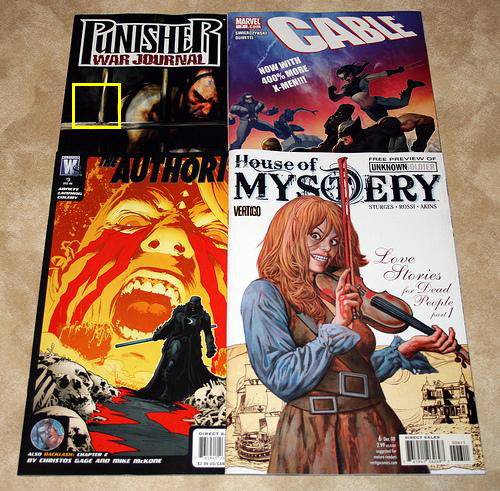

In [11]:
from torchvision.io import read_image

test_image = read_image("data/images/image_01.jpg")
test_transform_pipe = transformer.get_test_transform_pipe(640, 640)
model_input = test_transform_pipe(test_image)

model = model.to("cpu")
pred_box = model.predict(model_input)#, ground_truth=feature_label.unsqueeze(0))
print(pred_box.shape)

#test_image = fn.convert_image_dtype(image=test_image, dtype=torch.uint8)
bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=pred_box, width=3, colors=(255,255,0))

fn.to_pil_image(bbox_img_tensor)